<a href="https://colab.research.google.com/github/ed-chin-git/DS-Sprint-01-Dealing-With-Data/blob/master/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

In [26]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [27]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=339.9799541924636, mobile=False), User(purchased=True, time_on_site=469.7146910870995, mobile=False), User(purchased=False, time_on_site=172.02781122067375, mobile=True), User(purchased=False, time_on_site=111.49026319768528, mobile=True), User(purchased=False, time_on_site=197.24624133764792, mobile=True), User(purchased=False, time_on_site=9.056680287574018, mobile=True), User(purchased=False, time_on_site=10.344615201466638, mobile=True), User(purchased=False, time_on_site=273.9732592571206, mobile=True), User(purchased=True, time_on_site=412.7457848451787, mobile=False), User(purchased=False, time_on_site=167.90535244036406, mobile=True)]


In [28]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,339.979954,False
1,True,469.714691,False
2,False,172.027811,True
3,False,111.490263,True
4,False,197.246241,True


In [29]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.620151197803452,6.27180291078134,6.702928860124234,7.725432158668285,8.067768518008709,8.282013562368588,8.557117442587199,8.73284166339471,9.056680287574018,9.515225380799327,...,582.4560050306978,582.7493422617546,584.2040937562537,584.4328469074835,586.1471158617715,586.8898363023867,589.7351069649875,590.8070635329109,590.9046572271351,591.4408071712289
purchased,,,,,,,,,,,,,,,,,,,,,
False,0,1,1,1,1,1,1,1,1,1,...,1,0,1,0,1,1,1,0,1,1
True,1,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0


In [81]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(5.034, 122.784]","(122.784, 239.948]","(239.948, 357.113]","(357.113, 474.277]","(474.277, 591.441]"
purchased,,,,,
False,262,234,122,34,35
True,91,92,87,22,21


In [82]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(5.034, 122.784]","(122.784, 239.948]","(239.948, 357.113]","(357.113, 474.277]","(474.277, 591.441]"
purchased,,,,,
False,0.74221,0.717791,0.583732,0.607143,0.625
True,0.25779,0.282209,0.416268,0.392857,0.375


In [0]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

In [0]:
# More on binning
pd.cut(user_data['time_on_site'], 5)

In [0]:
help(pd.cut)

In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
pd.crosstab([user_data['purchased'], time_bins], user_data['mobile'],
            normalize='columns')

In [0]:
help(user_data.plot.bar)

In [0]:
user_data.plot.bar()

In [0]:
# So we have a working barchart method
# Does it just expand our crosstab?
ct = pd.crosstab([user_data['purchased'], time_bins], user_data['mobile'],
                 normalize='columns')
ct

In [0]:
dir(ct)

In [0]:
ct.plot(kind='bar', stacked=True)

In [0]:
# Courtesy of A
pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
            normalize='columns').plot(kind = 'bar', stacked = False);

In [0]:
# Starting point for mobile/desktop stacked barcharts
# Probably want to redo with fewer time-bins
pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins],
            normalize='columns').plot(kind = 'bar', stacked = True);

In [0]:
'scatter' in dir(ct.plot)

In [0]:
grouped_data = user_data['mobile'].groupby(user_data['purchased'])

In [0]:
dir(grouped_data)

In [0]:
# TODO continue exploring grouped_data, grouped_data.plot, etc.

In [0]:
[x for x in dir(ct) if 'add' in x]  # Courtesy of Ryan Herr

In [0]:
ct_props = dir(ct)
'add' in ct_props

In [0]:
ct.boxplot()

In [0]:
!apt install r-base

In [0]:
!R --version

In [0]:
!pip install rpy2

In [0]:
# Download the data
data_url = 'https://github.com/lockedata/datasauRus/raw/master/data/simpsons_paradox.rda'

!wget $data_url
!ls

In [0]:
!pip install tzlocal

In [0]:
# Trying to load R data in Python
# https://itsalocke.com/datasaurus/reference/simpsons_paradox
# https://stackoverflow.com/questions/40160149/reading-rda-file-in-python-as-a-pandas-data-frame#40161783

import rpy2.robjects as robjects
from rpy2.robjects import default_converter
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
pandas2ri.activate()

# load your file
robjects.r['load']('simpsons_paradox.rda')

# use the default conversion rules to which the pandas conversion
# is added
with localconverter(default_converter + pandas2ri.converter) as cv:
    df = robjects.r["data"]

matrix = robjects.r['data']

matrix

In [0]:
thing = df()

In [0]:
for item in thing.items():
  print(item)

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [46]:
import pandas as pd

# Load PERSONS.CSV from
# https://raw.githubusercontent.com/ed-chin-git/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv

data_url='https://raw.githubusercontent.com/ed-chin-git/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv'
df=pd.read_csv(data_url, index_col=0)


# Let's have a look
print('#Rows =',df.shape[0],'\n#Columns =',df.shape[1])
print('\n== data Types ==\n',df.dtypes,'\n')
df.head()

#Rows = 1200 
#Columns = 3

== data Types ==
 age              int64
weight           int64
exercise_time    int64
dtype: object 



,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [47]:
# Find NaN's 

print('\n== Nan list ==\n', df.isna().sum() )


== Nan list ==
 age              0
weight           0
exercise_time    0
dtype: int64


In [48]:
#  get some stats
df.describe()

,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000
mean,48.396667,153.540833,134.910833
std,18.166802,35.132182,85.548895
min,18.000000,100.000000,0.000000
25%,33.000000,125.000000,65.000000
50%,48.000000,149.000000,122.000000
75%,64.000000,180.250000,206.000000
max,80.000000,246.000000,300.000000


In [0]:
help (pd.cut)


In [129]:
pd.crosstab(df.age, df.weight)

# create 5 equal-sized bins of each column 
#  they are all continuous

time_bins = pd.cut(df['exercise_time'], 5  )  
age_bins = pd.cut(df['age'], 3,precision=0)  
weight_bins = pd.cut(df['weight'], 3,precision=0)



pd.crosstab(age_bins, [time_bins,weight_bins],normalize='columns')

exercise_time   (-0.3, 60.0]                                (60.0, 120.0]  \
weight        (100.0, 149.0] (149.0, 197.0] (197.0, 246.0] (100.0, 149.0]   
age                                                                         
(18.0, 39.0]        0.329412       0.315789       0.326531       0.299065   
(39.0, 59.0]        0.223529       0.263158       0.214286       0.214953   
(59.0, 80.0]        0.447059       0.421053       0.459184       0.485981   

exercise_time                               (120.0, 180.0]                 \
weight        (149.0, 197.0] (197.0, 246.0] (100.0, 149.0] (149.0, 197.0]   
age                                                                         
(18.0, 39.0]        0.241135       0.220588       0.417391       0.354839   
(39.0, 59.0]        0.262411       0.323529       0.286957       0.290323   
(59.0, 80.0]        0.496454       0.455882       0.295652       0.354839   

exercise_time                (180.0, 240.0]                                \
weight        (197.0, 246.0] (100.0, 149.0] (149.0, 197.0] (197.0, 246.0]   
age                                                                         
(18.0, 39.0]        0.266667       0.456693       0.523077            0.0   
(39.0, 59.0]        0.400000       0.354331       0.307692            0.0   
(59.0, 80.0]        0.333333       0.188976       0.169231            0.0   

exercise_time (240.0, 300.0]                                
weight        (100.0, 149.0] (149.0, 197.0] (197.0, 246.0]  
age                                                         
(18.0, 39.0]        0.402439       0.444444            0.0  
(39.0, 59.0]        0.567073       0.481481            0.0  
(59.0, 80.0]        0.030488       0.074074            0.0

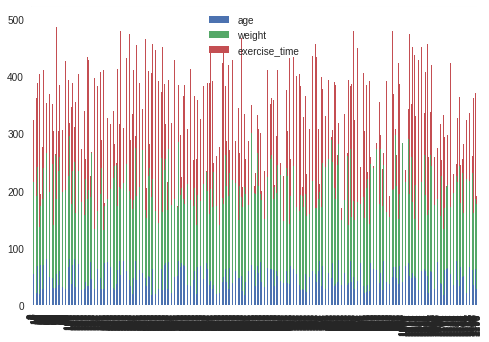

In [120]:
df.plot(kind='bar', stacked=True);


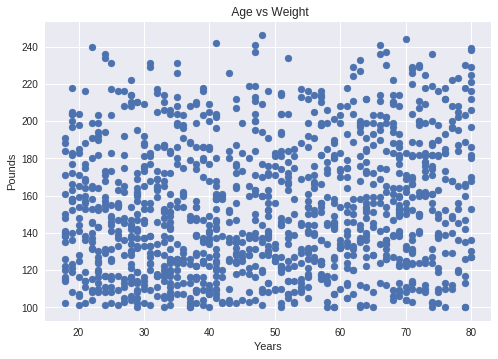

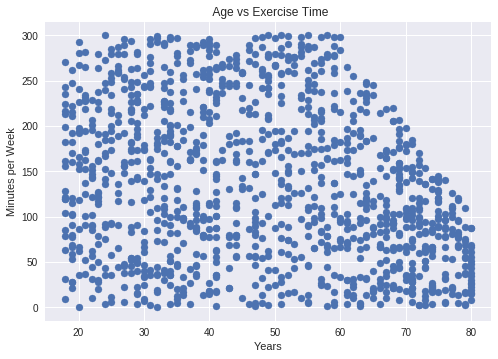

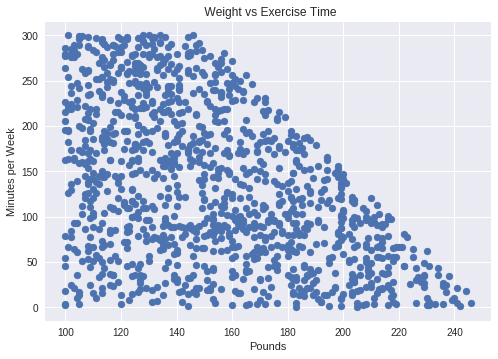

In [121]:
import matplotlib.pyplot as plt
plt.scatter(df.age,df.weight, marker = 'o')
plt.title(' Age vs Weight')
plt.xlabel('Years')
plt.ylabel('Pounds')
plt.show()

plt.scatter(df.age, df.exercise_time, marker = 'o')
plt.title(' Age vs Exercise Time')
plt.xlabel('Years')
plt.ylabel('Minutes per Week')
plt.show()

plt.scatter(df.weight, df.exercise_time, marker = 'o')
plt.title(' Weight vs Exercise Time')
plt.xlabel('Pounds')
plt.ylabel('Minutes per Week')
plt.show()


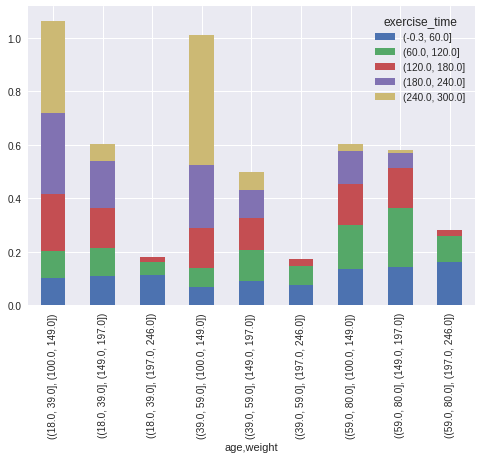

In [130]:
#  x_tab = pd.crosstab(time_bins, [age_bins,weight_bins],normalize='columns')

x_tab = pd.crosstab([age_bins,weight_bins],time_bins, normalize='columns')

x_tab.plot(kind='bar', stacked=True)



### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
                    The data contains a persons age, weight,  and amount of time they exercise. 


2.  What are the relationships between the variables?


3.  Which relationships are "real", and which spurious?
                   Age and weight  seem to spurious
                   Age and exercise time seem 'real'




## EXTRA WORK :  Crosstab  experimentation 

In [0]:
import pandas as pd
import seaborn as sns
# Define the headers since the data does not have any
headers = ["symboling", "normalized_losses", "make", "fuel_type", "aspiration",
           "num_doors", "body_style", "drive_wheels", "engine_location",
           "wheel_base", "length", "width", "height", "curb_weight",
           "engine_type", "num_cylinders", "engine_size", "fuel_system",
           "bore", "stroke", "compression_ratio", "horsepower", "peak_rpm",
           "city_mpg", "highway_mpg", "price"]

# Read in the CSV file and convert "?" to NaN
df_raw = pd.read_csv("http://mlr.cs.umass.edu/ml/machine-learning-databases/autos/imports-85.data",
                     header=None, names=headers, na_values="?" )

# Define a list of models that we want to review
models = ["toyota","nissan","mazda", "honda", "mitsubishi", "subaru", "volkswagen", "volvo"]

# Create a copy of the data with only the top 8 manufacturers
df = df_raw[df_raw.make.isin(models)].copy()

In [42]:
pd.crosstab(df.make, df.body_style)

body_style,convertible,hardtop,hatchback,sedan,wagon
make,,,,,
honda,0,0,7,5,1
mazda,0,0,10,7,0
mitsubishi,0,0,9,4,0
nissan,0,1,5,9,3
subaru,0,0,3,5,4
toyota,1,3,14,10,4
volkswagen,1,0,1,9,1
volvo,0,0,0,8,3


In [43]:
df.groupby(['make', 'body_style'])['body_style'].count().unstack().fillna(0)

body_style,convertible,hardtop,hatchback,sedan,wagon
make,,,,,
honda,0.0,0.0,7.0,5.0,1.0
mazda,0.0,0.0,10.0,7.0,0.0
mitsubishi,0.0,0.0,9.0,4.0,0.0
nissan,0.0,1.0,5.0,9.0,3.0
subaru,0.0,0.0,3.0,5.0,4.0
toyota,1.0,3.0,14.0,10.0,4.0
volkswagen,1.0,0.0,1.0,9.0,1.0
volvo,0.0,0.0,0.0,8.0,3.0


In [44]:
df.pivot_table(index='make', columns='body_style', aggfunc={'body_style':len}, fill_value=0)

body_style                              
body_style convertible hardtop hatchback sedan wagon
make                                                
honda                0       0         7     5     1
mazda                0       0        10     7     0
mitsubishi           0       0         9     4     0
nissan               0       1         5     9     3
subaru               0       0         3     5     4
toyota               1       3        14    10     4
volkswagen           1       0         1     9     1
volvo                0       0         0     8     3

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)